In [28]:
import urllib.request as libreq
import time
import xml.etree.ElementTree as ET
from datetime import datetime

# Paramètres de limitation
FREQUENCY_LIMIT = 4             # Maximum 1 requête toutes les 3 secondes

start_time = time.time()
end_time = start_time + 600  # durée d'exécution : 5 minutes
i = 0

filename = f'extractions/XML/arxiv_data_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xml'

with open(filename, 'ab') as f:
    while time.time() < end_time:
        start = str(i * 5000)
        max_results = str(5000)  # nombre maximum de résultats à récupérer

        # Construction de l'URL avec des paramètres distincts pour start et max_results
        url = f'http://export.arxiv.org/api/query?search_query=all&start={start}&max_results={max_results}'
        
        try:
            with libreq.urlopen(url) as response:
                r = response.read()
                # Écriture du contenu XML dans le fichier unique
                f.write(r)
        except libreq.HTTPError as e:
            error_data = e.read()
            try:
                # Parsing du XML de l'erreur pour extraire le contenu du tag <summary>
                root = ET.fromstring(error_data)
                summary = root.find('.//{http://www.w3.org/2005/Atom}summary')
                if summary is not None:
                    print(f"HTTP Error {e.code}: {summary.text}")
                else:
                    print(f"HTTP Error {e.code}: Erreur inconnue, impossible de trouver le résumé")
            except Exception as parse_error:
                print(f"HTTP Error {e.code}: Erreur lors du parsing du XML d'erreur - {parse_error}")
        except Exception as ex:
            print(f"Une autre erreur s'est produite: {ex}")
            
        
        time.sleep(FREQUENCY_LIMIT)
        i += 1


In [30]:
import pandas as pd

import xml.etree.ElementTree as ET

XML_file = f'extractions/XML/arxiv_data_20250304_093007.XML'
CSV_file = f'extractions/CSV/arxiv_data_{time.time()}.csv'

# Define the namespace dictionary for XML parsing
namespaces = {
    'atom': 'http://www.w3.org/2005/Atom',
    'arxiv': 'http://arxiv.org/schemas/atom'
}

# Function to parse a single entry
def parse_entry(entry):
    # Extract basic information
    article = {
        'id': entry.find('atom:id', namespaces).text,
        'title': entry.find('atom:title', namespaces).text.strip(),
        'published': entry.find('atom:published', namespaces).text,
        'updated': entry.find('atom:updated', namespaces).text,
        'summary': entry.find('atom:summary', namespaces).text.strip(),
    }
    
    # Extract authors
    authors = [author.find('atom:name', namespaces).text 
              for author in entry.findall('atom:author', namespaces)]
    article['authors'] = '; '.join(authors)
    
    # Extract DOI if available
    doi = entry.find('arxiv:doi', namespaces)
    article['doi'] = doi.text if doi is not None else None
    
    # Extract categories
    primary_category = entry.find('arxiv:primary_category', namespaces)
    article['primary_category'] = primary_category.get('term') if primary_category is not None else None
    
    return article

# Parse the XML file and create a list of articles
articles = []

# Read and process the XML content
with open(XML_file, 'r', encoding='utf-8', errors='replace') as file:
    content = file.read()

# Split the content properly at the XML document boundaries
xml_docs = content.split('<?xml version="1.0" encoding="UTF-8"?>')
for doc in xml_docs:
    if not doc.strip():  # Skip empty strings
        continue
    
    # Reconstruct proper XML document
    doc = '<?xml version="1.0" encoding="UTF-8"?>' + doc
    try:
        root = ET.fromstring(doc)
        # Process each entry
        entries = root.findall('.//atom:entry', namespaces)
        for entry in entries:
            article_data = parse_entry(entry)
            articles.append(article_data)
    except ET.ParseError as e:
        print(f"Skipping malformed XML document: {str(e)}")
        continue

# Create DataFrame and save to CSV
df = pd.DataFrame(articles)
df.to_csv(CSV_file, index=False)
print(f"Processed {len(articles)} articles")

Processed 15000 articles


In [31]:
len(df.id.unique())

15000

In [32]:
df.head()

,id,title,published,updated,summary,authors,doi,primary_category
0,http://arxiv.org/abs/2401.04381v1,Spaces where all bijections are morphisms,2024-01-09T07:01:04Z,2024-01-09T07:01:04Z,Here we classify all topological spaces where ...,Lucas H. R. de Souza,None,math.GN
1,http://arxiv.org/abs/1911.11405v1,A Note on Computational Complexity of Kill-all Go,2019-11-26T08:49:54Z,2019-11-26T08:49:54Z,Kill-all Go is a variant of Go in which Black ...,Zhujun Zhang,None,cs.CC
2,http://arxiv.org/abs/2501.13404v1,Classification of Homogeneous Local Representa...,2025-01-23T06:06:47Z,2025-01-23T06:06:47Z,"For a natural number $n$, denote by $B_n$ the ...",Taher I. Mayassi; Mohamad N. Nasser,None,math.RT
3,http://arxiv.org/abs/1210.7708v1,Landau--Kolmogorov inequality revisited,2012-10-29T16:12:41Z,2012-10-29T16:12:41Z,The Landau-Kolmogorov problem consists of find...,Alexei Shadrin,None,math.NA
4,http://arxiv.org/abs/1602.00450v1,All-in-all-out magnetic domain wall conduction...,2016-02-01T09:53:30Z,2016-02-01T09:53:30Z,"Pyrochlore oxides possessing ""all-in-all-out"" ...",T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A...,10.1103/PhysRevB.93.064419,cond-mat.mtrl-sci


In [33]:
print(len(df.primary_category.unique()))

163


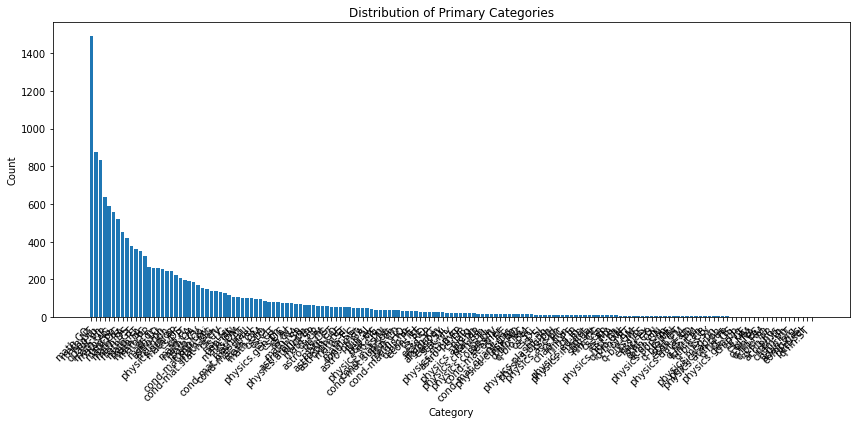

In [34]:
import matplotlib.pyplot as plt
cats = df.primary_category.value_counts()
plt.figure(figsize=(12, 6))
plt.bar(cats.index, cats.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Primary Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()

In [41]:
len(df.authors.unique())

13845

In [216]:
authors = df.authors.unique()
authors

array(['Lucas H. R. de Souza', 'Zhujun Zhang',
       'Taher I. Mayassi; Mohamad N. Nasser', ...,
       'Tomasz Gogacz; Jerzy Marcinkowski',
       'Florent Foucaud; Michael Krivelevich; Guillem Perarnau',
       'John Golden; Miguel F. Paulos; Marcus Spradlin; Anastasia Volovich'],
      dtype=object)

In [119]:
test = 'Taher I. Mayassi; Mohamad N. Nasser'
first = list(test.partition(';'))
out = []
for i in range(0, len(first), 2):
    out.append(first[i])

print(out)

def list_authors(str_authors):
    l = list(str_authors.partition(';'))
    out = []
    for i in range(0, len(l), 2):
        out.append(l[i])
    
    return out
print(list_authors('T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki'))

['Taher I. Mayassi', ' Mohamad N. Nasser']
['T. C. Fujita', ' M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki']


In [140]:
import numpy as np 

test = 'T. C. Fujita; M. Uchida; Y. Kozuka; W. Sano; A. Tsukazaki; T. Arima; M. Kawasaki'

def auth_str_to_list(auth_str):
    copy = auth_str
    still_separable = True
    out = []
    while still_separable:
        idx = copy.find(';')
        if idx == -1:
            out.append(copy.strip())
            still_separable = False
        else:
            out.append(copy[:idx].strip())
            copy = copy[idx+1:]

    return out

auth_str_to_list(test)


['T. C. Fujita',
 'M. Uchida',
 'Y. Kozuka',
 'W. Sano',
 'A. Tsukazaki',
 'T. Arima',
 'M. Kawasaki']

In [ ]:
unique_authors = []
for auth in authors:
    l_authors = auth_str_to_list(auth)
    for author in l_authors:
        unique_authors.append(author)

print(len(unique_authors))

In [ ]:

network = {author:[] for author in unique_authors}
for i in range(len(df)):
    paper_authors = df.iloc[i].authors
    authors_list = auth_str_to_list(paper_authors)
    nbr_authors = len(authors_list)
    if nbr_authors > 1:
        for j in range(nbr_authors):
            for k in range(nbr_authors):
                if j != k:
                    network[authors_list[j]] += [authors_list[k]]



[]


In [262]:

for i in range(0,10):
    print(network[unique_authors[i]])
    

[]
[]
['Mohamad N. Nasser']
['Taher I. Mayassi']
[]
['M. Uchida', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'M. Uchida', 'Y. Kozuka', 'S. Ogawa', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'Y. Kozuka', 'M. Uchida', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki']
['T. C. Fujita', 'Y. Kozuka', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'T. C. Fujita', 'Y. Kozuka', 'S. Ogawa', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'T. C. Fujita', 'Y. Kozuka', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki']
['T. C. Fujita', 'M. Uchida', 'W. Sano', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'T. C. Fujita', 'M. Uchida', 'S. Ogawa', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki', 'T. C. Fujita', 'M. Uchida', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'A. Tsukazaki', 'T. Arima', 'M. Kawasaki']
['T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'W. Sano', 'T. Arima', 'M. Kawasaki', 'T. C. Fujita', 'M. Uchida', 'Y. Kozuka', 'S. Ogawa', 'T. Arima', 'M. 